# Coding Attention Mechanisms

## 3.3: Attending to different parts of the input with self-attention

Self-attention serves as the cornerstone of every LLM based on the transformer architecture. It is the key to understand how modern transformers-based LLMs work.

The *self* in self-attention refers to the mechanism's ability to learn and assess the relationships and dependencies between various parts of the input itself, e.g. words in a sentence.

In comparison, previous attention mechanisms focused on relationship between elements of 2 different sequences, e.g. input sequence (in French) and output sequence (in English).

### 3.3.1: A simple self-attention mechanism without trainable weights

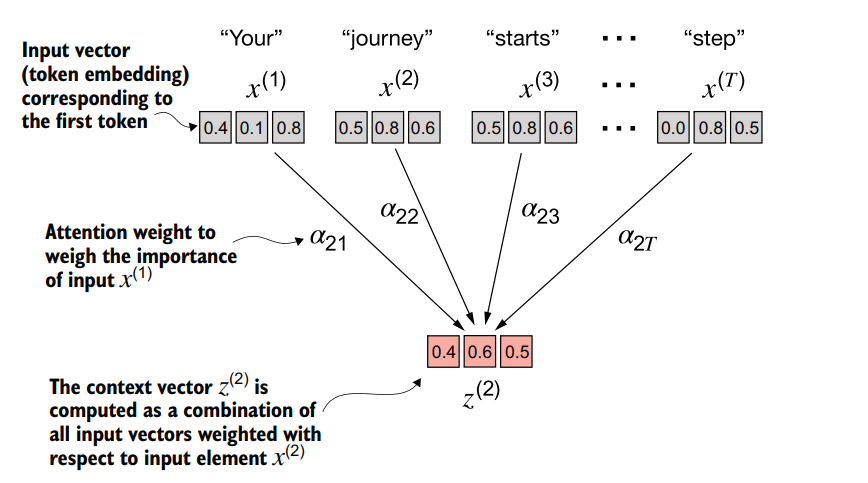

Context vectors play a crucial role in self-attention. Their purpose is to create enriched representations of each element in an input sequence (like a sentence) by incorporating information from all other elements in the sequence

Let's consider the sentence "Your journey starts with one step" and consider each word/token has a 3 (d=3) dimensional vector.

In [1]:
# Let's consider that we've already converted the sentence into 3-dimensional embeddings

import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)

c:\Users\Vansh\Desktop\Coding\Build a Large Language Model From Scratch\.venv\lib\site-packages\torch\_subclasses\functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


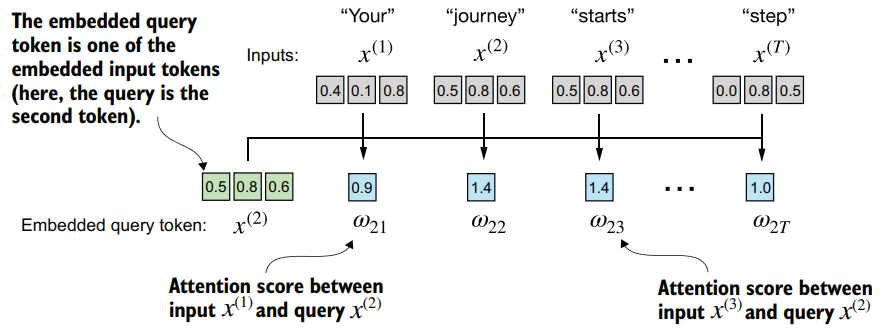

The first step of implementing self-attention is to compute the intermediate values ω, referred to as attention scores as shown in the figure above.

NOTE: In the figure due to spatial constraints, the embeddings have been shortened to 1 decimal place and the embeddings for 'journey' and 'starts' appear similar by chance.

In [2]:
# Calculating intermediate attention scores

query = inputs[1]           # Query vector (Considering 'journey' here)
attn_scores_2 = torch.empty(inputs.shape[0])    # Initializes attention scores of each word w.r.t. 'journey' to empty tensor of size 6 (number of words in the sentence)
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(query, x_i)    # Calculates dot product of query vector and each word vector

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


According to the intermediate attention scores, 'journey' is most closely related to 'journey' itself and 'start' as the scores are the highest there, indicating a dependency/relationship.

Similarly, as the scores for 'one' and 'with' are the lowest, 'journey', the weakest dependency/relationship is between 'journey' and 'one' followed by 'journey' and 'with'.

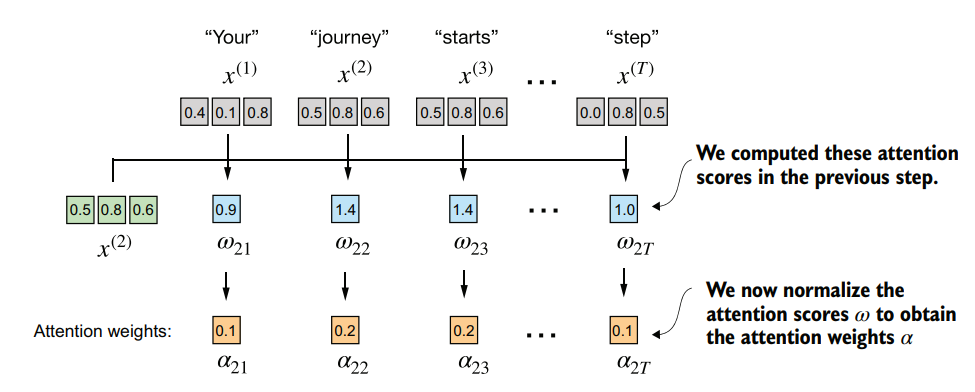

Now we normalize the attention scores that we've just calculated. The purpose here is to get attention scores that add up to 1. Normalization is helpful in maintaining training stability as well as interpretability.

In [3]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In practice, it’s more common and advisable to use the softmax function for normalization. Softmax offers more fovourable gradient properties during training and handles extreme values better.

Softmax also results in the values adding up to 1, while ensuring that no value is negative. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [4]:
# Basic implementation of softmax function

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Our implementation of softmax may encounter numerical instability, such as overflow and underflow, therefore it is advisable to use the official PyTorch implementation.

In [5]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [6]:
query = inputs[1]           # Query vector (Considering 'journey' here)
context_vec_2 = torch.zeros(query.shape)        # Initializes context vector of 'journey' to zero tensor of size 3
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i      # Calculates context vector of 'journey' by summing up the product of attention weights and word vectors
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


Our next step is to generalize this procedure so that we can simultaneously compute all the context vectors.

### 3.3.2: Computing attention weights for all input tokens